# dEdx fit

In [6]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16

from readdata import get_data
from tpcplot import draw_g4xyz
from tracklen import process_track, plot_dedx
from recoclusters import digits_to_clusters, pixid2position

In [7]:
data_path = 'tracks'

In [8]:
trkfilter = json.load(open('trkfilter.json', 'r'))
trkfilter.keys()

dict_keys(['mu_100.0', 'mu_150.0', 'mu_200.0', 'mu_250.0', 'mu_300.0', 'mu_400.0', 'mu_500.0', 'mu_600.0', 'mu_1500.0', 'pi_100.0', 'pi_150.0', 'pi_200.0', 'pi_250.0', 'pi_300.0', 'pi_400.0', 'pi_500.0', 'pi_600.0', 'pi_1500.0', 'e_100.0', 'e_150.0', 'e_200.0', 'e_250.0', 'e_300.0', 'e_400.0', 'e_500.0', 'e_600.0', 'e_1500.0', 'K_150.0', 'K_200.0', 'K_250.0', 'K_300.0', 'K_400.0', 'K_500.0', 'K_600.0', 'K_1500.0', 'p_250.0', 'p_300.0', 'p_400.0', 'p_500.0', 'p_600.0', 'p_1500.0'])

In [9]:
def get_keys(files):
    return [os.path.splitext(os.path.split(item)[-1])[0] for item in files]

In [10]:
files = sorted(glob.glob(f'{data_path}/*.npy'))
keys = get_keys(files)
data = {key: fname for key, fname in zip(keys, files)}
', '.join(data.keys())

'K_100.0, K_150.0, K_1500.0, K_200.0, K_250.0, K_300.0, K_400.0, K_500.0, K_600.0, e_100.0, e_150.0, e_1500.0, e_200.0, e_250.0, e_300.0, e_400.0, e_500.0, e_600.0, mu_100.0, mu_150.0, mu_1500.0, mu_200.0, mu_250.0, mu_300.0, mu_400.0, mu_500.0, mu_600.0, p_1500.0, p_250.0, p_300.0, p_400.0, p_500.0, p_600.0, pi_100.0, pi_150.0, pi_1500.0, pi_200.0, pi_250.0, pi_300.0, pi_400.0, pi_500.0, pi_600.0'

In [11]:
def apply_filter(ds, cuts):
    (llo, lhi), (elo, ehi) = cuts
    return ds[(ds[:, 1] < lhi) & (ds[:, 1] > llo) & (ds[:, 2] < ehi) & (ds[:, 2] > elo)]

In [30]:
key = 'mu_1500.0'
ds = apply_filter(np.load(data[key]), trkfilter[key])[:, 2]

In [31]:
from scipy.stats import moyal

In [32]:
pdf = moyal()
x0, s0 = moyal.fit(ds)
x0, s0

(0.21488528387796985, 0.026019481506116843)

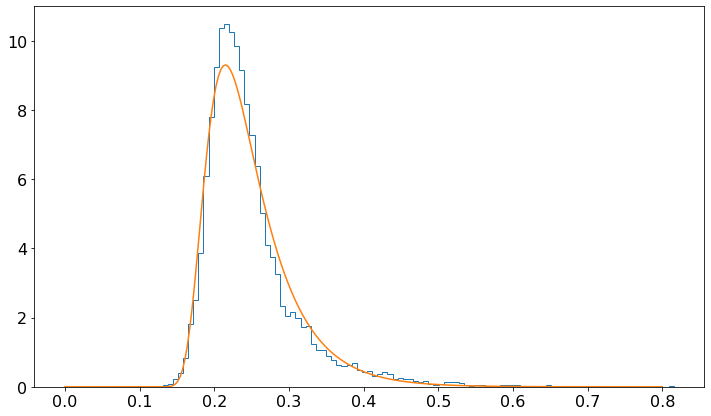

In [33]:
x = np.linspace(0, 0.8, 250)
y = moyal.pdf(x, x0, s0)
plt.figure(figsize=(12, 7))
plt.hist(ds, bins=100, density=True, histtype='step')
plt.plot(x, y);